In [1]:
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("ggplot")
get_ipython().magic('matplotlib inline')
from math import *
import numpy as np
import pickle as pkl
import skimage as ski
from skimage.color import rgb2gray
from scipy import misc
from PIL import Image
import PIL.ImageOps
from skimage.exposure import adjust_gamma
from randomwalkmaker import *


In [2]:
#dict_matrix_to_num, dict_num_to_weights = pkl.load( open ("myDicts.p", "rb") )
#a = dict_num_to_weights[0]
#print(a)
#plt.imshow(dict_num_to_weights[0])
#plt.show()

In [3]:
class Cell:
    def __init__(self, pop_list, veg_type, veg_value, hum_value, iswater): #pop_list is array, veg_type is string, veg_value is the vegetation index value, hum_value is the humidity value
        self.larvae_lim_per_box = 1000
        self.pop_list  = pop_list
        self.veg_type  = veg_type
        self.veg_value = veg_value
        self.hum_value = hum_value
        self.iswater = iswater

        self.e = pop_list[0]  # e  = eggs    - aquatic steps
        self.l = pop_list[1]  # l  = larvae  - aquatic steps
        self.p = pop_list[2]  # p  = pupae   - aquatic steps

        self.ah = pop_list[3] # ah = host-seeking        adult - adult steps
        self.ar = pop_list[4] # ar = resting             adult - adult steps
        self.ao = pop_list[5] # ao = ovoposition-seeking adult - adult steps
        
        self.amale = sum(pop_list[3:])

        self.emut = 0 #emut = mutant eggs
        self.lmut = 0 #lmut = mutant larvae
        self.pmut = 0 #pmut = mutant pupae
        self.amut = 0 #amut = mutant adults
        
        self.n_total   = pop_list.sum()
        self.n_aquatic = sum(pop_list[0:3])
        self.n_adult   = sum(pop_list[3:])
        
        #U for dying P for passing
        self.B = 100     #number of eggs per ovoposition
        self.PE = .50    #prob of becoming a larvae
        self.UE = .56    #prob of dying as a egg
        self.novopo = 1.3 #novopositions per day #max =1.48, maxefficient=1.4
        self.UL1 = .44   #prob of dying larvae
        self.UL2 = .1  #prob of dying due to crowding
        self.PL = 0.14   #prob of 
        self.PP = .50
        self.UP = .37
        self.PAH = .46 
        self.UAH = .18
        self.PAR = .43
        self.UAR = .0043
        self.UAO = .41
        self.PAO = .5
        self.UAM = .15

    def update(self):
        
        a = 0; b =1
        if self.l < self.larvae_lim_per_box: a = (1 - (self.l+ self.lmut)/self.larvae_lim_per_box)
        allmale = self.amale + self.amut
        if (self.amale + self.amut) != 0:
            factor = (self.amale/allmale)
            mutfactor = 1 - factor
        else: factor = 0; mutfactor = 0
        
            
        deltae = self.PAO*self.B*self.novopo*self.ao*factor - self.e*self.UE - self.e*self.PE   #egg value update
        deltal = self.PE*self.e      - self.l*self.UL1  - self.l*self.PL*a                                    # larvae value update
        deltap = self.PL*self.l*a    - self.p*self.UP   - self.p*self.PP                                      #pupae update value
        deltaah = self.PP*self.p/2   - self.ah*self.UAH - self.ah*self.PAH + self.PAO*self.ao           #host-seeking update value
        deltaar = self.PAH*self.ah   - self.ar*self.UAR - self.ar*self.PAR                                  #resting update value
        deltaao = self.ar*self.PAR   - self.PAO*self.ao - self.UAO*self.ao                                  #ovoposition seeking update value
        deltaamale =  self.PP*self.p/2 - self.amale*self.UAM 
        
        deltaemut = self.PAO*self.B*self.novopo*self.ao*mutfactor - self.emut*self.UE - self.emut*self.PE #mutant egg value update
        deltalmut = self.PE*self.emut    - self.lmut*self.UL1  - self.lmut*self.PL*a                                #mutant larvae value update
        deltapmut = self.PL*self.lmut*a  - self.pmut*self.UP   - self.pmut*self.PP                                  #mutant pupae update value
        deltaamut = self.PP*self.pmut       - self.amut*self.UAM                                                       #mutant adult value update

        self.pop_list = self.pop_list.tolist() #change from array to list as array is imutable in function
        self.e     += deltae                      # egg   value update
        self.l     += deltal                      #larvae value update
        self.p     += deltap
        self.ah    += deltaah
        self.ar    += deltaar
        self.ao    += deltaao
        self.amale += deltaamale
        self.emut  += deltaemut
        self.lmut  += deltalmut
        self.pmut  += deltapmut
        self.amut  += deltaamut
        
        if self.e < 0  : self.e  = 0
        if self.l < 0  : self.l  = 0
        if self.p < 0  : self.p  = 0
        if self.ah < 0 : self.ah = 0
        if self.ar < 0 : self.ar = 0
        if self.ao < 0 : self.ao = 0
        if self.amale < 0 : self.amale = 0
        if self.emut < 0 : self.emut = 0
        if self.lmut < 0 : self.lmut = 0
        if self.pmut < 0 : self.pmut = 0
        if self.amut < 0 : self.amut = 0
            
        self.pop_list = np.array([self.e,self.l,self.p,self.ah,self.ar, self.ao])
        self.n_total   = self.pop_list.sum()
        self.n_aquatic = sum(self.pop_list[0:3])
        self.n_adult   = sum(self.pop_list[3:])

In [4]:
class Grid:
    def __init__(self, basearray, contour, vegimage, twiimage, cityimage, pixelXmeters):
        self.internalclock = 0
        self.shape = contour.shape
        self.contour = contour
        self.vegimage = abs(vegimage-1)
        self.twiimage = abs(twiimage-1)
        self.cityimage = cityimage
        self.pixelSize = pixelXmeters
        self.maxstep = MaxStep(pixelXmeters)
        print("migration dt = "+ str(self.maxstep/60))
        self.dict_matrix_to_num, self.dict_num_to_weights = weightDictmaker(self.maxstep, 10000,pixelXmeters )

        #initializing grid of Cells
        self.GRID = [[Cell(np.array(basearray)*abs(1-contour[j][i]), cityimage[j][i], vegimage[j][i], twiimage[j][i], contour[j][i]) for i in range(self.shape[1])] for j in range(self.shape[0])]

        #create grid of types of contour
        def neighbors_to_tuple(y,x):
            return(int(contour[y-1,x-1]), int(contour[y,x-1]), int(contour[y+1,x-1]), int(contour[y-1,x]), int(contour[y+1,x]), int(contour[y-1,x+1]), int(contour[y,x+1]), int(contour[y+1,x+1]))
        self.bordertype = [[self.dict_matrix_to_num[neighbors_to_tuple(j,i)] for i in range(1,self.shape[1]-1)] for j in range(1,self.shape[0]-1)]
        self.bordertype = np.pad(self.bordertype, pad_width=((1,1),(1,1)), mode='constant', constant_values=-1) #padding with zeros
        

        
    def getSingleGrid(self, ending):
        if ending == "e"    :  return np.array([[self.GRID[j][i].e  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "l"    :  return np.array([[self.GRID[j][i].l  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "p"    :  return np.array([[self.GRID[j][i].p  for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ah"   :  return np.array([[self.GRID[j][i].ah for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ar"   :  return np.array([[self.GRID[j][i].ar for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "ao"   :  return np.array([[self.GRID[j][i].ao for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "aqua" : return self.getSingleGrid("e")   + self.getSingleGrid("l") + self.getSingleGrid("p")
        if ending == "adult": return self.getSingleGrid("ah")  + self.getSingleGrid("ar")+ self.getSingleGrid("ao")
        if ending == "all"  : return self.getSingleGrid("aqua")+ self.getSingleGrid("adult")
        if ending == "amale": return np.array([[self.GRID[j][i].amale for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "amut" : return np.array([[self.GRID[j][i].amut for i in range(self.shape[1])] for j in range(self.shape[0])])
        if ending == "aquamut": return np.array([[self.GRID[j][i].emut+self.GRID[j][i].lmut+self.GRID[j][i].pmut  for i in range(self.shape[1])] for j in range(self.shape[0])])
        print("wrong command on getSingleGrid"); return np.array([[]])
        
    def grdsum(self, ending):
        grid_to_sum = self.getSingleGrid(ending)
        return grid_to_sum.sum()
        
    def update_pop(self):
        [[self.GRID[j][i].update() for i in range(self.shape[1])] for j in range(self.shape[0])]
    
    def update_migration(self):
        updatedah   = np.zeros(self.shape)
        updatedao   = np.zeros(self.shape)
        updatedamale = np.zeros(self.shape)
        updatedamut  = np.zeros(self.shape)
        for i in range(1, self.shape[0]-1):
            for j in range(1, self.shape[1]-1):
                if self.GRID[i][j].iswater == 0:
                    borderMatrix = np.array(self.dict_num_to_weights[self.bordertype[i][j]])
                    
                    floatingah = self.GRID[i][j].ah * borderMatrix * self.vegimage[i-1:i+2,j-1:j+2]
                    if floatingah.sum() > 0.05: 
                        updatedah[i-1:i+2,j-1:j+2]   += floatingah*(self.GRID[i][j].ah/floatingah.sum())
                    else: updatedah[i-1:i+2,j-1:j+2] += self.GRID[i][j].ah * borderMatrix 
                            
                    floatingao = self.GRID[i][j].ao * borderMatrix * self.twiimage[i-1:i+2,j-1:j+2]
                    if floatingao.sum() > 0.05: 
                        updatedao[i-1:i+2,j-1:j+2]  += floatingao*(self.GRID[i][j].ao/floatingao.sum())
                    else:updatedah[i-1:i+2,j-1:j+2] += self.GRID[i][j].ao * borderMatrix
                        
                    floatingamale = self.GRID[i][j].amale * borderMatrix
                    if floatingamale.sum() > 0.05: 
                        updatedamale[i-1:i+2,j-1:j+2]   += floatingamale*(self.GRID[i][j].amale/floatingamale.sum())
                    else: updatedamale[i-1:i+2,j-1:j+2] += self.GRID[i][j].amale * borderMatrix 
                        
                    floatingamut = self.GRID[i][j].amut * borderMatrix
                    if floatingamut.sum() > 0.05: 
                        updatedamut[i-1:i+2,j-1:j+2]   += floatingamut*(self.GRID[i][j].amut/floatingamut.sum())
                    else: updatedamut[i-1:i+2,j-1:j+2] += self.GRID[i][j].amut * borderMatrix 
                    
        for i in range(1, self.shape[0]-1):
            for j in range(1, self.shape[1]-1):
                self.GRID[i][j].ah = updatedah[i][j]
                self.GRID[i][j].ao = updatedao[i][j]
                self.GRID[i][j].amale = updatedamale[i][j]
                self.GRID[i][j].amut = updatedamut[i][j]
    
    def updateall(self):
        for i in range(int(24*60/self.maxstep)):
            self.update_migration()
        self.update_pop()
        self.internalclock += 1
        
    def images(self):
        f, (aquatics, ao, adults) = plt.subplots(ncols=3, figsize=(15,15)) # sharex=True, sharey=True
        caq = aquatics.imshow(self.getSingleGrid('aqua') + self.getSingleGrid('aquamut'), cmap=plt.get_cmap("gist_earth"))
        aquatics.set_title('Aquatics stages')
        divider1 = make_axes_locatable(aquatics)
        cax1 = divider1.append_axes("bottom", size="5%", pad=0.05)
        f.colorbar(caq,cax1,orientation="horizontal") #  a = int(self.grdsum("aqua") ,ticks = range(0, a, int(a/10)

        
        #cah=ah.imshow(self.getSingleGrid('ah'), cmap=plt.get_cmap("gist_earth"))
        #ah.set_title('host-seeking')
        #divider2 = make_axes_locatable(ah)
        #cax2 = divider2.append_axes("bottom", size="5%", pad=0.05)
        #f.colorbar(cah,cax2, orientation="horizontal")
        
        cao=ao.imshow(self.getSingleGrid('amut'), cmap=plt.get_cmap("gist_earth"))
        ao.set_title('Mutant males')
        divider3 = make_axes_locatable(ao)
        cax3 = divider3.append_axes("bottom", size="5%", pad=0.05)
        f.colorbar(cao,cax3, orientation="horizontal")
        
        caa=adults.imshow(self.getSingleGrid('adult'), cmap=plt.get_cmap("gist_earth"))
        adults.set_title('Adult females')
        divider4 = make_axes_locatable(adults)
        cax4 = divider4.append_axes("bottom", size="5%", pad=0.05)
        f.colorbar(caa,cax4, orientation="horizontal")

        f.subplots_adjust(hspace=0)
        plt.title(str(self.internalclock)+" days after release")
        plt.setp([a.get_xticklabels() for a in f.axes[:]], visible=False)
        #for a in f.axes[:]: a.axis([0, self.shape[1],0, self.shape[0]])
        plt.setp([a.get_yticklabels() for a in f.axes[:]], visible=False)
        plt.tight_layout()
        plt.show()
                


In [5]:
island_shape = misc.imread("../example_images/region_border_example.png")
island_shape_gray = rgb2gray(island_shape)
island_wet = ski.img_as_float(rgb2gray(misc.imread("../example_images/TWI_example.png")))
island_veg = ski.img_as_float(rgb2gray(misc.imread("../example_images/vegetation_index_example.png")))
island_city = rgb2gray(misc.imread("../example_images/city_delimitation_example.png"))

In [6]:
%%time
%time mosquitos = Grid([100,100,100,100,100,100], island_shape_gray, island_veg, island_wet, island_city, 68)

%time for i in range(10): mosquitos.update_pop()
%time for i in range(10):mosquitos.update_migration()
    
for i in range(-15,15):
    for j in range(-15,15):
        mosquitos.GRID[280+i][140+j].amut = 800
        mosquitos.GRID[200+i][200+j].amut = 800
        mosquitos.GRID[320+i][330+j].amut = 800
        mosquitos.GRID[100+i][300+j].amut = 800


migration dt = 4.0
256
CPU times: user 5min, sys: 528 ms, total: 5min 1s
Wall time: 5min 1s
CPU times: user 1min 30s, sys: 24 ms, total: 1min 30s
Wall time: 1min 30s
CPU times: user 1min 42s, sys: 1.62 s, total: 1min 44s
Wall time: 1min 43s
CPU times: user 8min 13s, sys: 2.17 s, total: 8min 15s
Wall time: 8min 15s


In [7]:
#%time mosquitos.update_pop()


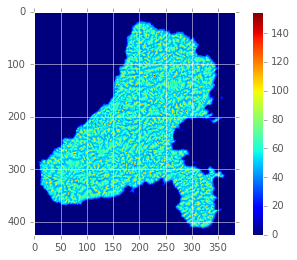

In [8]:
plt.imshow(mosquitos.getSingleGrid("adult"))
plt.colorbar()
plt.show()

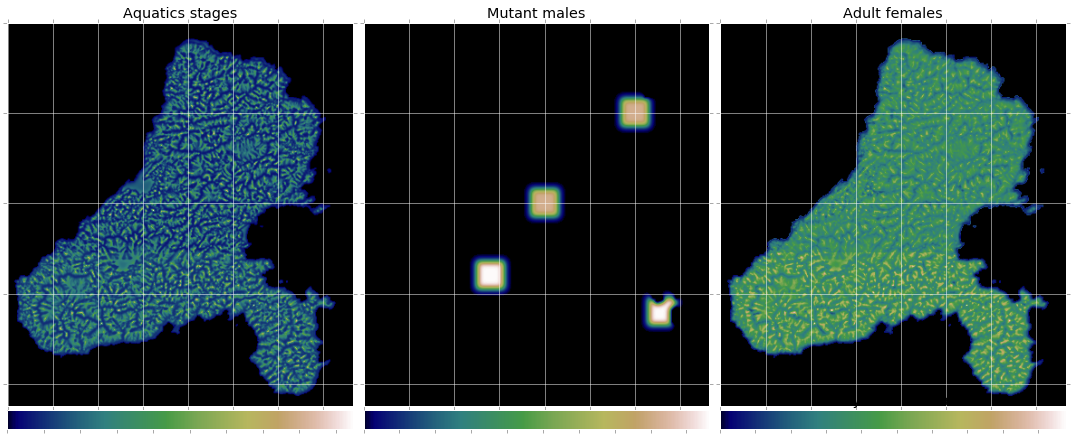

CPU times: user 1.88 s, sys: 864 ms, total: 2.74 s
Wall time: 1.78 s
CPU times: user 52.8 s, sys: 588 ms, total: 53.4 s
Wall time: 52.7 s


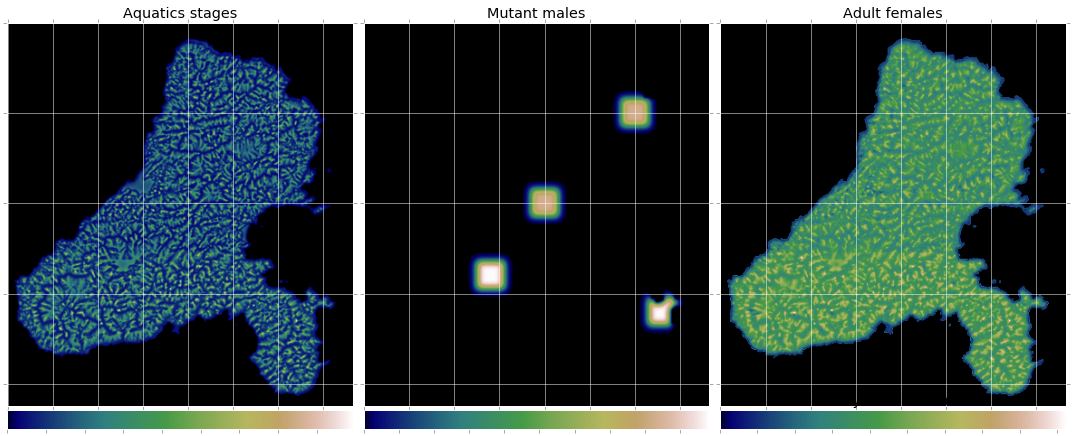

CPU times: user 1.94 s, sys: 816 ms, total: 2.75 s
Wall time: 1.83 s
CPU times: user 55.1 s, sys: 496 ms, total: 55.6 s
Wall time: 55 s


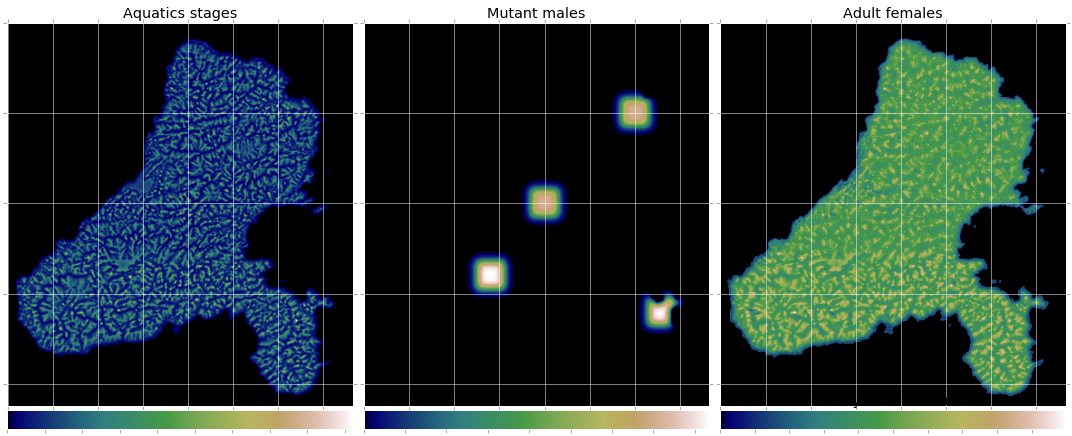

CPU times: user 2.02 s, sys: 1.01 s, total: 3.03 s
Wall time: 1.93 s
CPU times: user 1min, sys: 612 ms, total: 1min 1s
Wall time: 1min


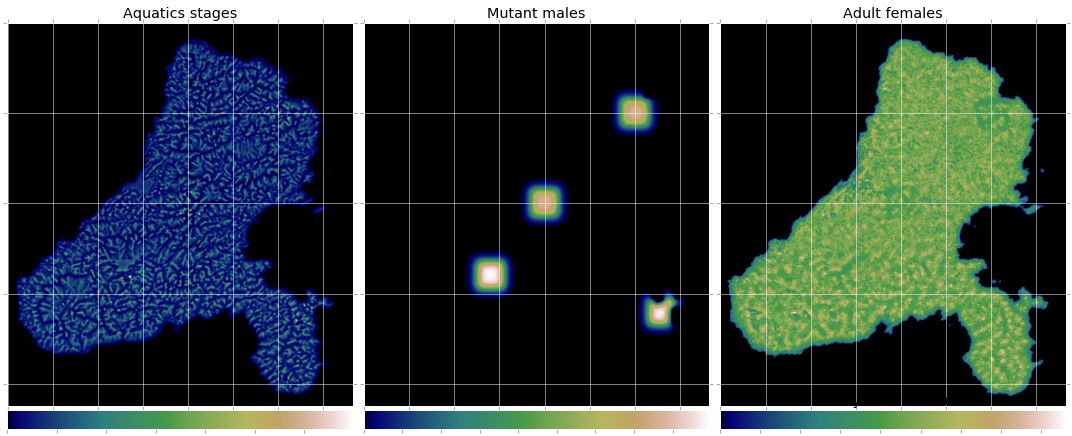

CPU times: user 2.02 s, sys: 856 ms, total: 2.88 s
Wall time: 1.94 s
CPU times: user 1min 3s, sys: 872 ms, total: 1min 4s
Wall time: 1min 3s


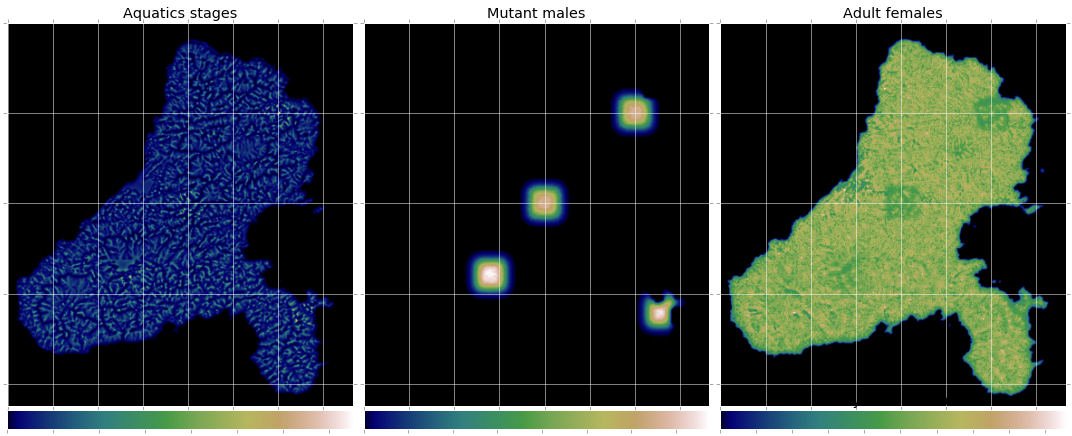

CPU times: user 1.98 s, sys: 868 ms, total: 2.84 s
Wall time: 1.86 s
CPU times: user 53 s, sys: 520 ms, total: 53.5 s
Wall time: 52.9 s


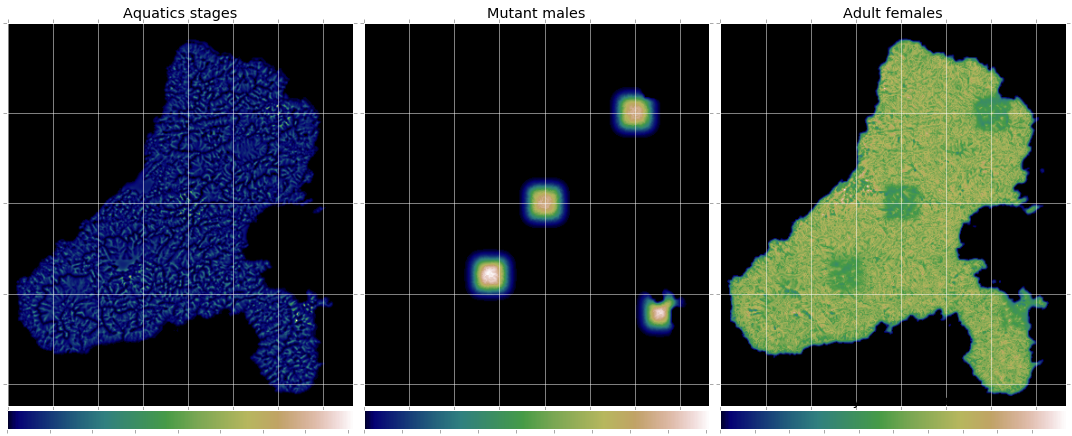

CPU times: user 1.91 s, sys: 952 ms, total: 2.86 s
Wall time: 1.8 s
CPU times: user 58.1 s, sys: 656 ms, total: 58.8 s
Wall time: 58 s


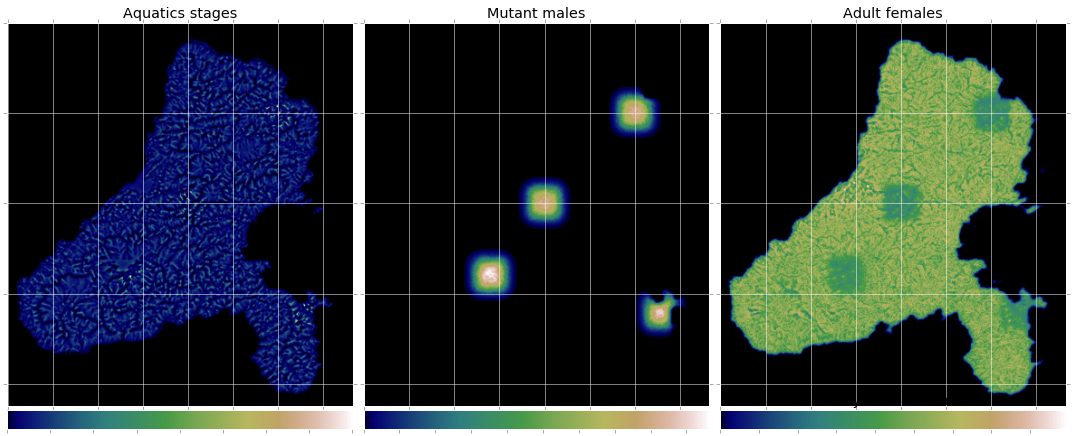

CPU times: user 2.95 s, sys: 1.28 s, total: 4.22 s
Wall time: 2.86 s
CPU times: user 58.7 s, sys: 856 ms, total: 59.5 s
Wall time: 58.7 s


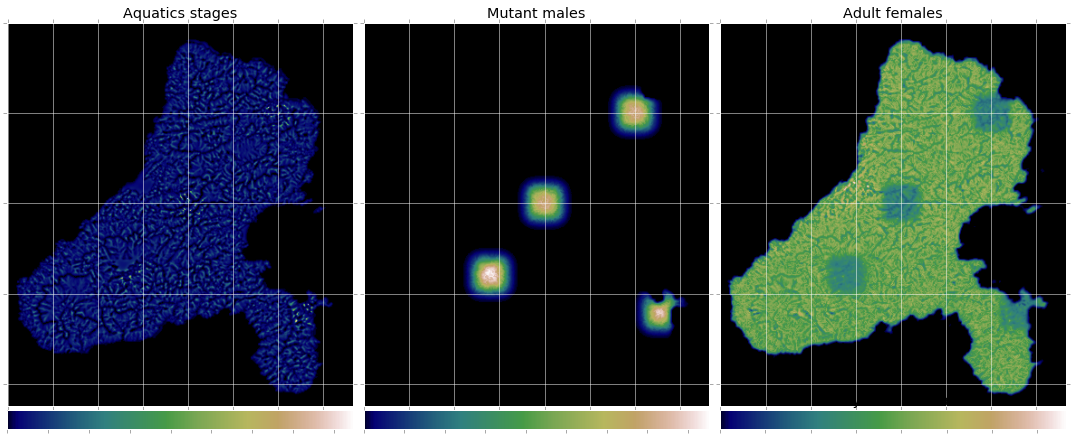

CPU times: user 2.16 s, sys: 908 ms, total: 3.06 s
Wall time: 2.04 s
CPU times: user 57.8 s, sys: 520 ms, total: 58.3 s
Wall time: 57.6 s


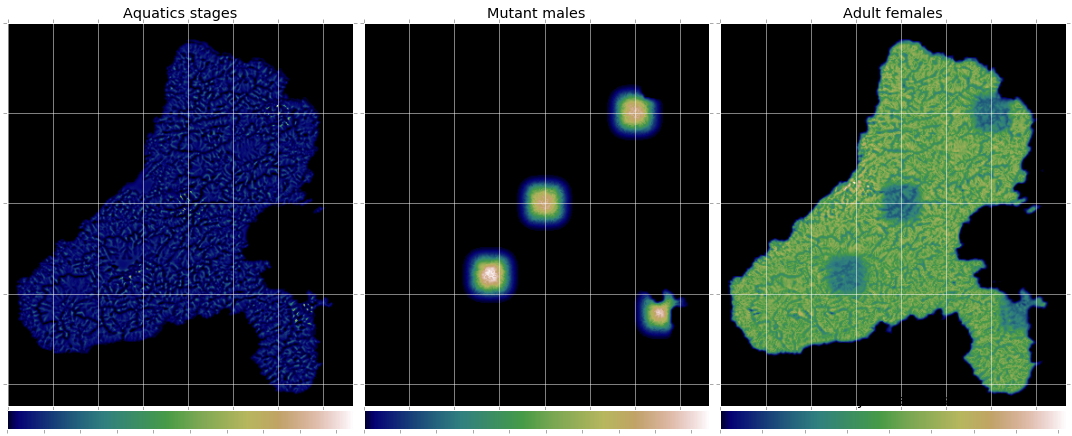

CPU times: user 3.24 s, sys: 1.47 s, total: 4.7 s
Wall time: 3.1 s
CPU times: user 1min 1s, sys: 696 ms, total: 1min 2s
Wall time: 1min 1s


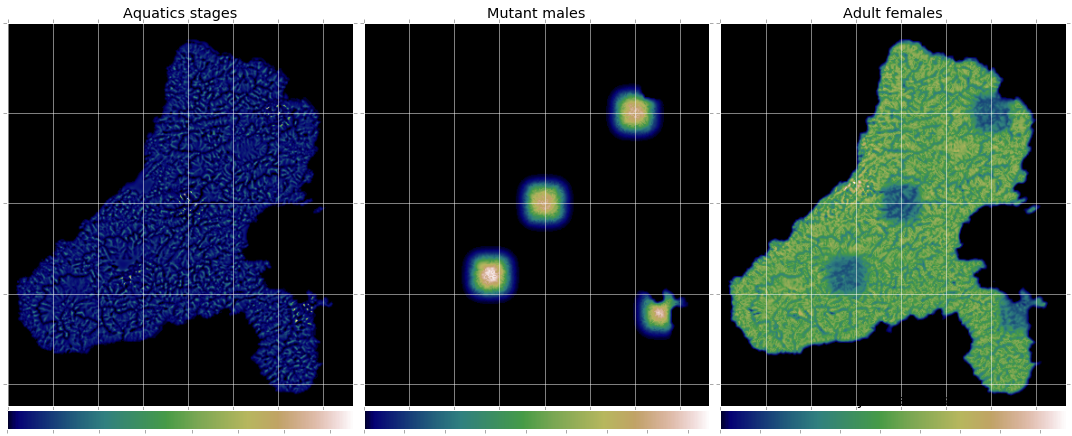

CPU times: user 2.28 s, sys: 936 ms, total: 3.22 s
Wall time: 2.16 s
CPU times: user 1min, sys: 752 ms, total: 1min
Wall time: 1min


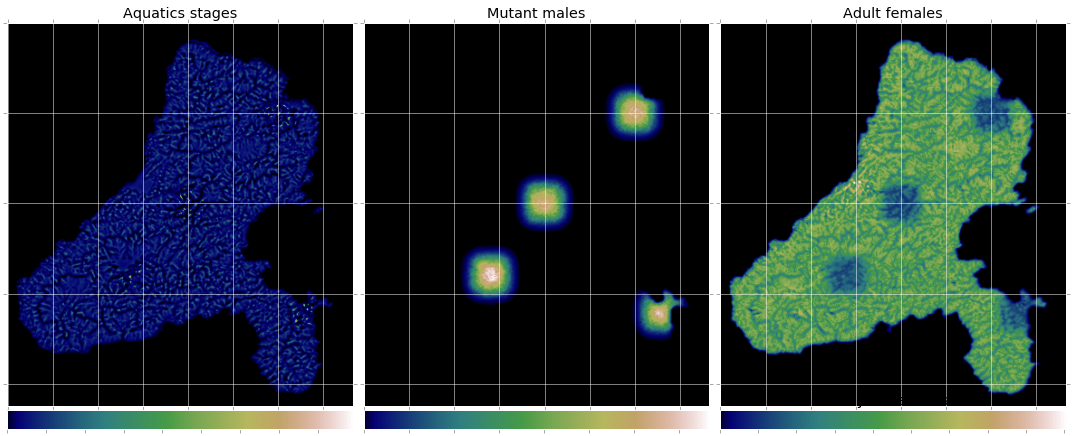

CPU times: user 2.85 s, sys: 1.05 s, total: 3.9 s
Wall time: 2.75 s
CPU times: user 1min 4s, sys: 788 ms, total: 1min 5s
Wall time: 1min 4s


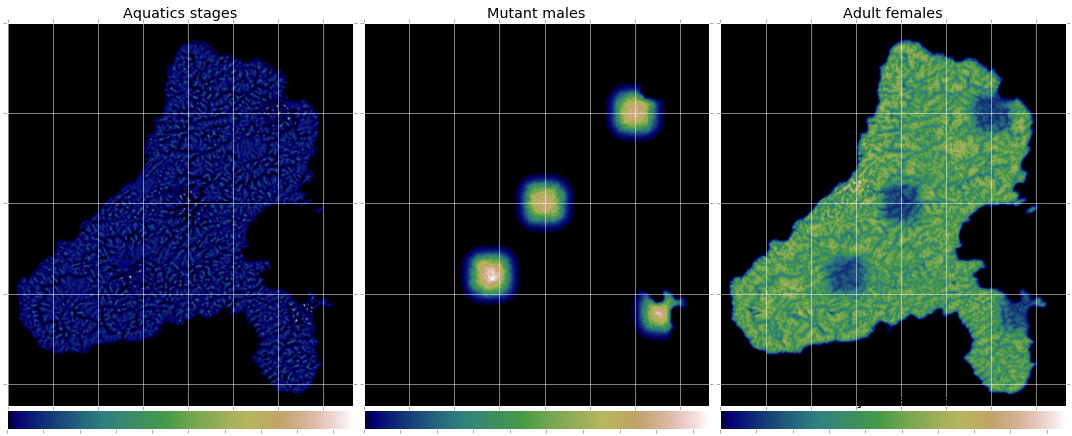

CPU times: user 2.42 s, sys: 984 ms, total: 3.41 s
Wall time: 2.27 s
CPU times: user 1min 1s, sys: 768 ms, total: 1min 2s
Wall time: 1min 1s


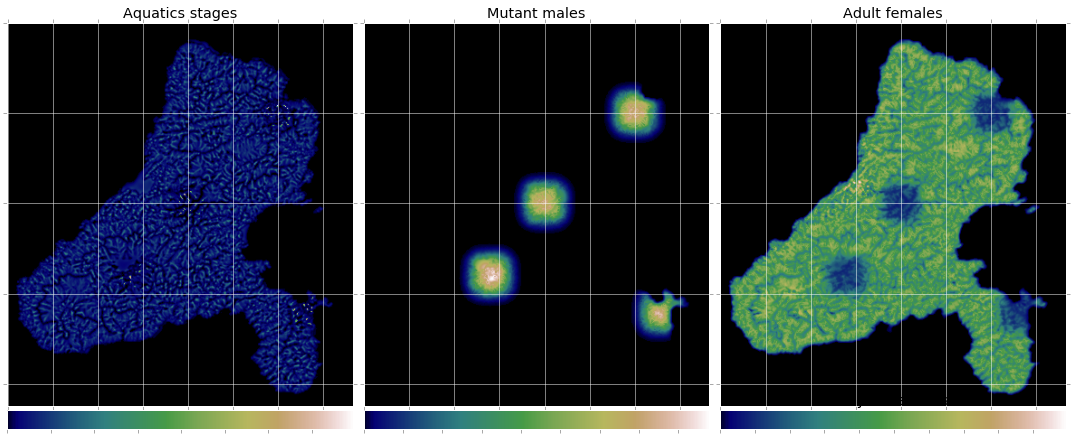

CPU times: user 2.23 s, sys: 1.02 s, total: 3.26 s
Wall time: 2.14 s
CPU times: user 56.8 s, sys: 948 ms, total: 57.7 s
Wall time: 56.7 s


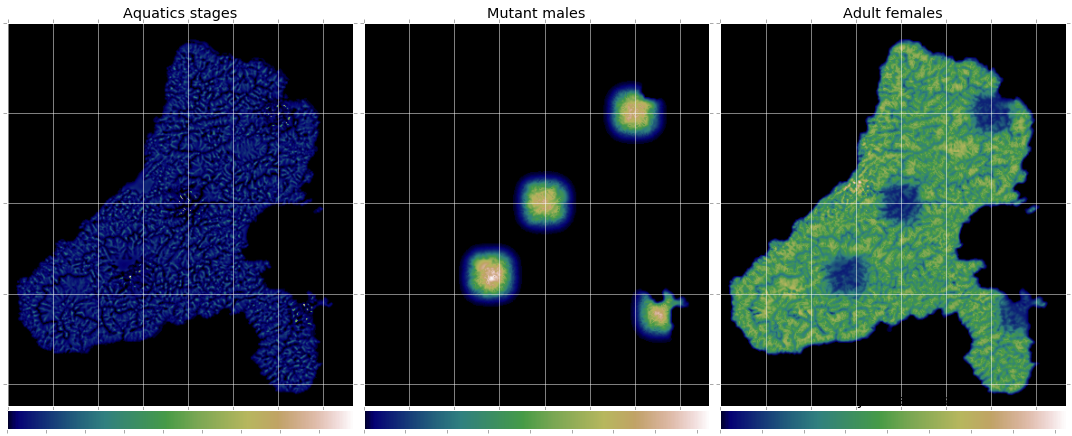

CPU times: user 2.2 s, sys: 1.03 s, total: 3.23 s
Wall time: 2.07 s
CPU times: user 56.9 s, sys: 776 ms, total: 57.6 s
Wall time: 56.8 s


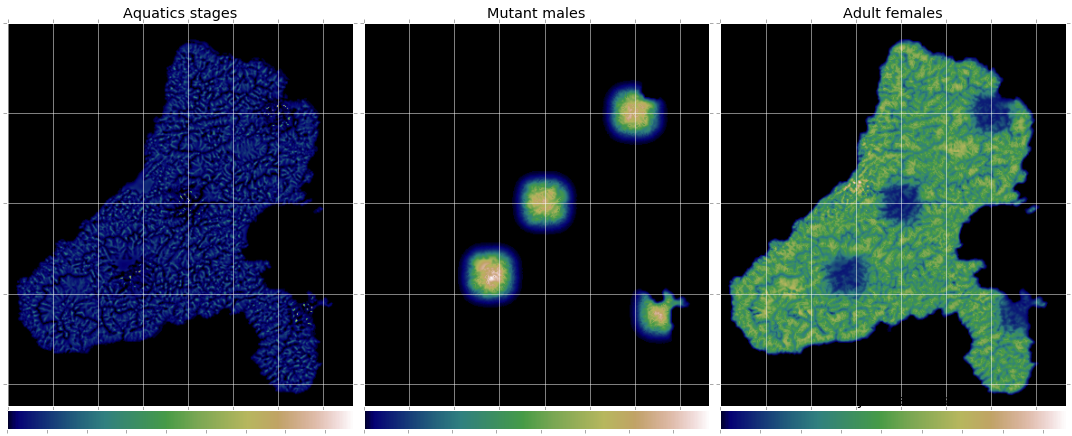

CPU times: user 2.4 s, sys: 872 ms, total: 3.27 s
Wall time: 2.27 s
CPU times: user 57.1 s, sys: 596 ms, total: 57.7 s
Wall time: 57 s


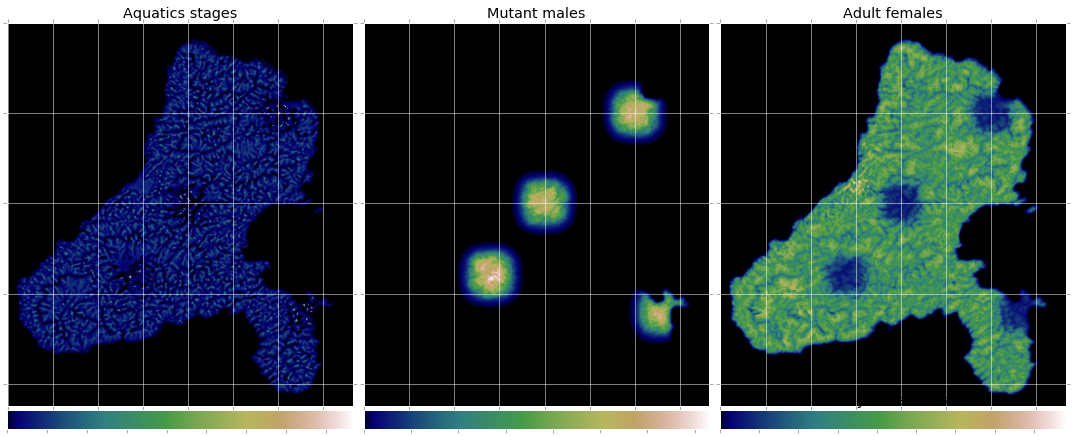

CPU times: user 2.04 s, sys: 848 ms, total: 2.89 s
Wall time: 1.92 s
CPU times: user 1min 3s, sys: 796 ms, total: 1min 4s
Wall time: 1min 3s


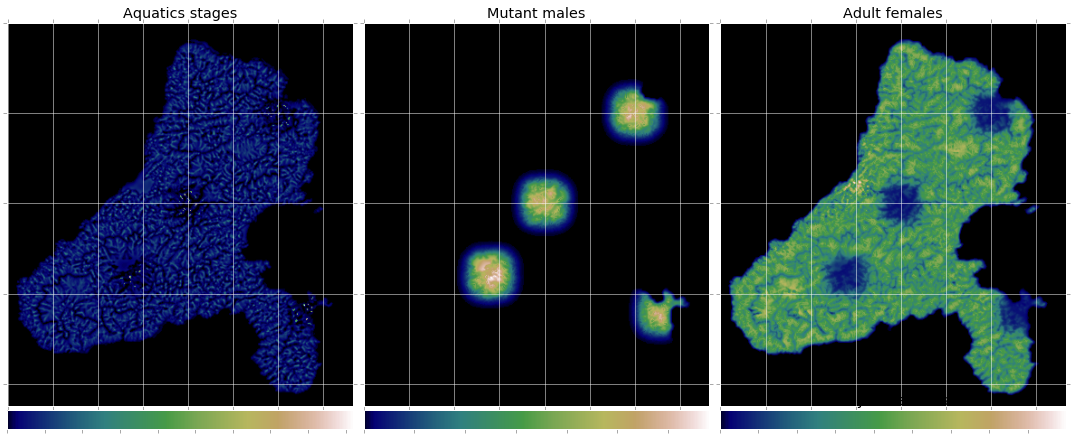

CPU times: user 2.42 s, sys: 920 ms, total: 3.34 s
Wall time: 2.24 s
CPU times: user 57.8 s, sys: 560 ms, total: 58.3 s
Wall time: 57.8 s


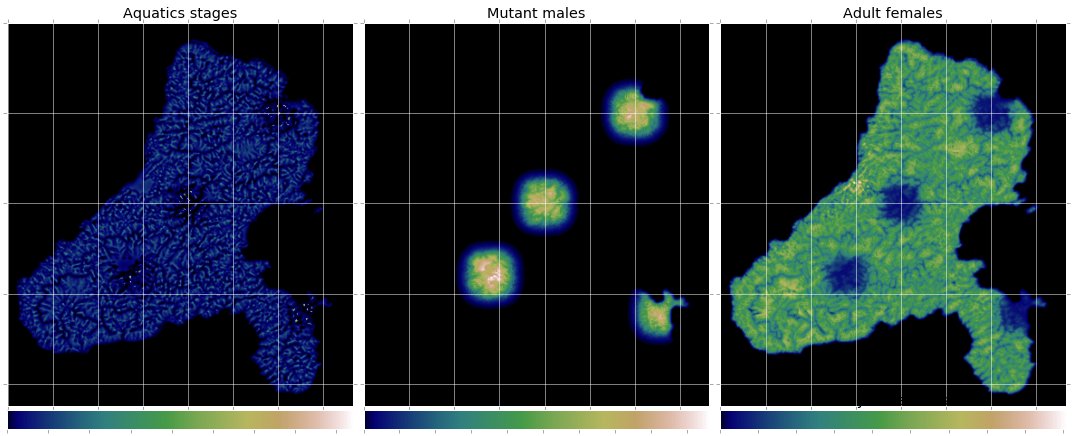

CPU times: user 3.38 s, sys: 1.28 s, total: 4.66 s
Wall time: 3.17 s
CPU times: user 59.2 s, sys: 832 ms, total: 1min
Wall time: 59.1 s


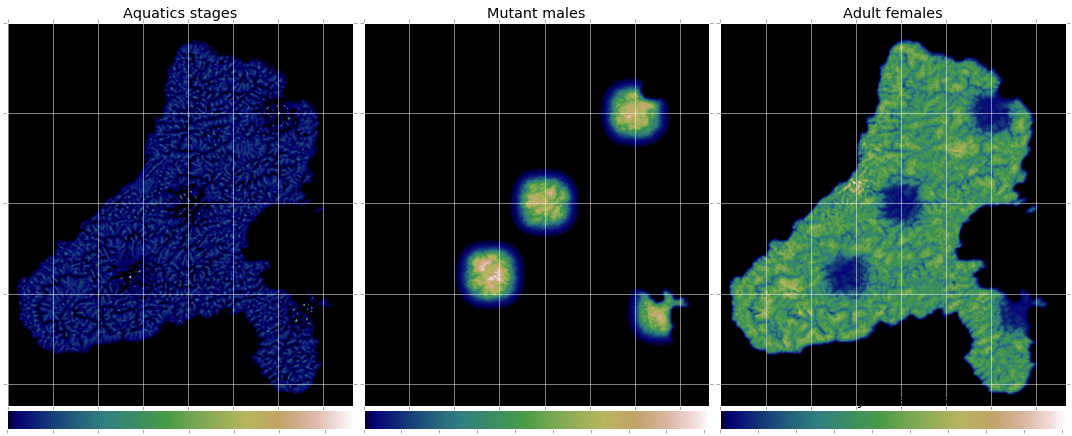

CPU times: user 2.23 s, sys: 928 ms, total: 3.16 s
Wall time: 2.09 s
CPU times: user 1min, sys: 712 ms, total: 1min
Wall time: 1min


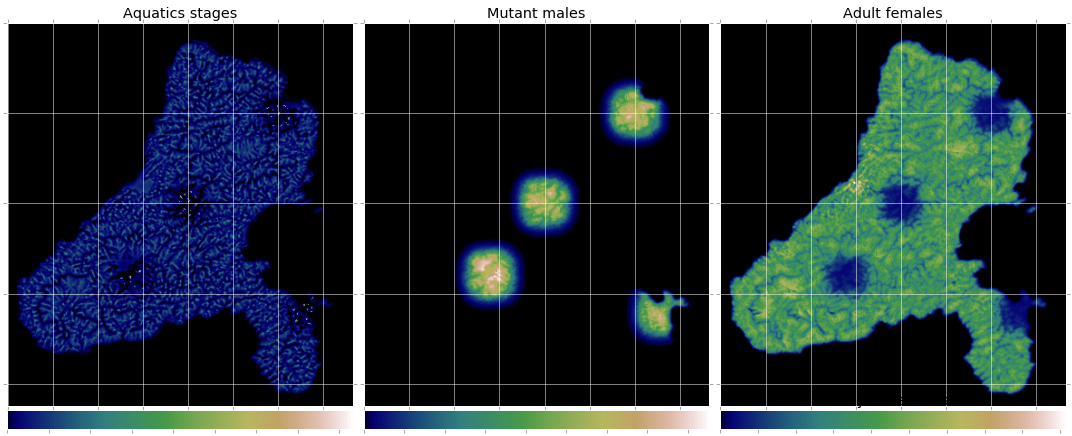

CPU times: user 1.97 s, sys: 924 ms, total: 2.9 s
Wall time: 1.84 s
CPU times: user 1min 6s, sys: 704 ms, total: 1min 6s
Wall time: 1min 6s


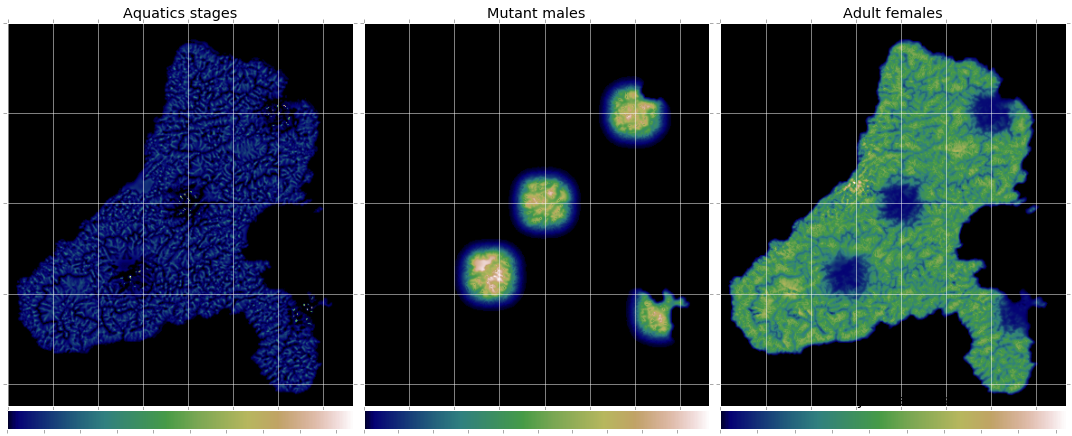

CPU times: user 2.55 s, sys: 844 ms, total: 3.39 s
Wall time: 2.36 s


55258474.880046517

In [10]:
mosquitos.grdsum("all")
%time mosquitos.images()
for i in range(20): 
    %time mosquitos.updateall()
    %time mosquitos.images()
mosquitos.grdsum("all")

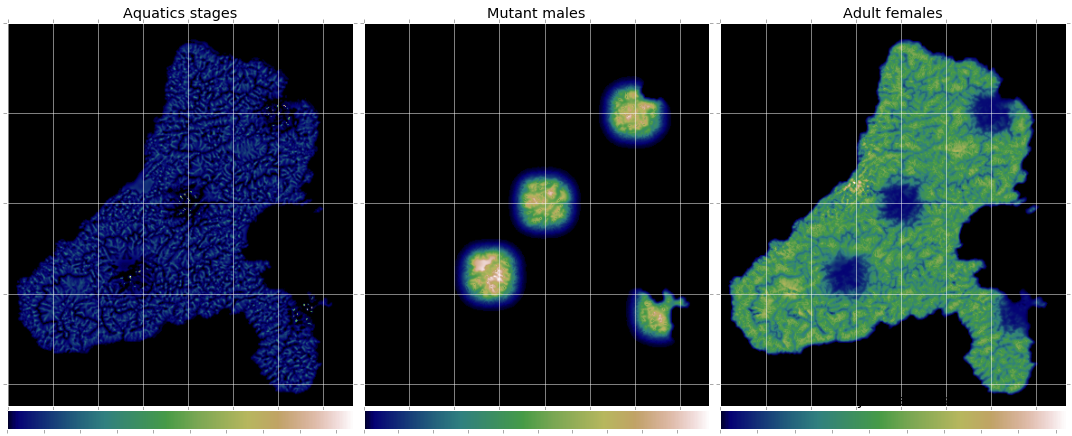

In [11]:
mosquitos.images()

0


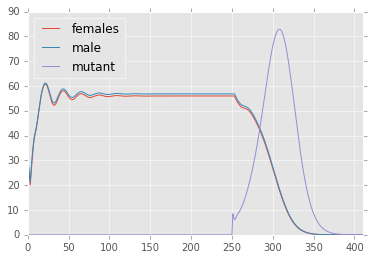

In [18]:
test = Cell(np.array([10,10,10,10,10,10]),1,1,1,1)
ovo = [test.e]
larva= [test.l]
pupa= [test.p]
ahlist= [test.ah]
arlist= [test.ar]
aolist= [test.ao]
amalelist = [test.amale]
amutlist = [test.amut]
adultlist = [test.n_adult]
print(test.amut)
for i in range(250):
    test.update()
    ovo    += [test.e]
    larva  += [test.l]
    pupa   += [test.p]
    adultlist += [test.n_adult]
    amalelist  += [test.amale]
    amutlist  += [test.amut]
    
test.amut = 10

for i in range(300):
    test.update()
    ovo    += [test.e]
    larva  += [test.l]
    pupa   += [test.p]
    adultlist += [test.n_adult]
    amalelist  += [test.amale]
    amutlist  += [test.amut]
plt.plot(range(len(ovo)),adultlist, label = 'females')
plt.plot(range(len(ovo)), amalelist, label = 'male')
plt.plot(range(len(ovo)), amutlist, label = 'mutant')
#plt.ylim([0, 10000])
plt.xlim([0, 410])
plt.legend(loc = "best")
plt.show()